<a href="https://colab.research.google.com/github/yilin10/MusicalGenreClassification/blob/master/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Music Languages and System - Assignment 1

## Introduction

This is a report for Computer Music: Language and Systesms in Politecnico di Milano. It is written as IPython Notebook using Google Colaboratory.

The report version [link](https://www.overleaf.com/1494782774kwgkjvfgddzq)


## Imports

Import of **Libraries** we needed in this project.

In [0]:
# import python libraries
import librosa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy as sp
from tqdm.notebook import tqdm
from time import sleep

# import classification and evaluation
import sklearn.svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import datasets
import sklearn.neighbors as neighbors
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

We can use the personal **Kaggle Api token** to enable download from Kaggle.

In [11]:
from google.colab import files
files.upload() # Choose kaggle.json (your personal Kaggle API token)

! rm -r ~/.kaggle
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json # Change the permissions of the file.

Saving kaggle.json to kaggle.json


Download of the dataset from Kaggle, and unzip the dataset



In [12]:
! pip install -q kaggle
! mkdir ~/dataset
! kaggle datasets download -d carlthome/gtzan-genre-collection
! unzip -q gtzan-genre-collection.zip -d ~/dataset

mkdir: cannot create directory ‘/root/dataset’: File exists
gtzan-genre-collection.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /root/dataset/genres/blues/blues.00000.au? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Observation and Retrieving Annotations


The original Dataset we are using is from [Kaggle](https://www.kaggle.com/carlthome/gtzan-genre-collection) and provided by [GTZAN](http://marsyas.info/downloads/datasets.html), which is the most widely used free database in music genre recognization field.

In our Task **Group 5 Assignment 1**, we need to classify the four Music Genre categories **Blues, Metal, Hip-Hop, Reggae**.


In the description part, we can see the brief infomation on this data set.



```
The dataset consists of 1000 audio tracks each 30 seconds long. 

It contains 10 genres, each represented by 100 tracks. 

The tracks are all 22050 Hz monophonic 16-bit audio files in .au format.
```




In [13]:
# save data in genre.csv
genre_analysis_list = ["blues","metal","hiphop","reggae"]  
genre_list = []  
path_list = []
train_path = "../root/dataset/genres/"

for each in tqdm(genre_analysis_list):
    train_test_folder = train_path + format(each)
    train_catg_files = [f for f in os.listdir(train_test_folder) if f.endswith('.au')]
    for index, each_file in enumerate(train_catg_files):
        each_file_path = os.path.join(train_test_folder, each_file)
        genre_list.append(each)
        path_list.append(each_file_path)
genre_data = pd.DataFrame(list(zip(genre_list,path_list)),columns = ['Genre','Path'])
genre_data.to_csv('./genres.csv',sep = '\t', index = False)

genre_data # get pd.DataFrame

,Genre,Path
0,blues,../root/dataset/genres/blues/blues.00025.au
1,blues,../root/dataset/genres/blues/blues.00058.au
2,blues,../root/dataset/genres/blues/blues.00044.au
3,blues,../root/dataset/genres/blues/blues.00022.au
4,blues,../root/dataset/genres/blues/blues.00018.au
...,...,...
395,reggae,../root/dataset/genres/reggae/reggae.00088.au
396,reggae,../root/dataset/genres/reggae/reggae.00020.au
397,reggae,../root/dataset/genres/reggae/reggae.00069.au
398,reggae,../root/dataset/genres/reggae/reggae.00023.au


## Preprocessing

Go through the files and check .au basic info, we can pick random samples to check according to statistic principle.
- sample rate
- duration in seconds
- static tempo

By executing the following code we can get the same information on this dataset which confirms with the provided info.

In [14]:
import warnings 
# ignore dw warning from librosa.beat
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# get 20% of check_sample from original dataset
check_sample = genre_data['Path'].sample(frac = 0.2, replace = False,
                                         random_state = None, axis = 0 )
sr_list = []
dur_list = []
tempo_list = []
for p in tqdm(check_sample):
    #read audio file 
    y, sr = librosa.load(p) 
    #1. get sample rate
    sr_list.append(sr)
    #2. get duration
    dur = round(librosa.get_duration(y=y, sr=sr))
    dur_list.append(dur)
    #3. static tempo
    onset_env = librosa.onset.onset_strength(y, sr=sr)
    tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
    tempo_list.append(round(tempo[0]))
    #4. 
print("sample rate: ", sr_list) # sample rate = 22050
print("duration in seconds: ", dur_list)
print("static tempo: ", tempo_list)


sample rate:  [22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050]
duration in seconds:  [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
static tempo:  [136.0, 117.0, 103.0, 144.0, 117.0, 129.0, 136.0, 144.0, 99.0, 117

In [15]:
print("--- Statistics for sample data in static tempo ---")
print("Mean", np.mean(tempo_list))
print("Min",np.min(tempo_list))
print("Max",np.min(tempo_list))
print("Median", np.median(tempo_list))
print("Std", np.std(tempo_list))

--- Statistics for sample data in static tempo ---
Mean 119.3875
Min 89.0
Max 89.0
Median 117.0
Std 20.578808122678048


Here we can print to see the statistic info in tempo as a test. We can see in rhythmic part the standard diviation is quiet obvious, which makes it possible to distinguish different different genres.

**Check the quality of the Original dataset**

- if it is balanced
- if it has repetition
- if it is able to describe differnet genre

According to a research result we found [[1]](https://arxiv.org/abs/1306.1461), the audio pieces from GTZAN is not perfect, it does have repetitions, and dislabelling error.

In the research result we find from the paper, they checked each audio piece both using fingerprinting of the audio and also human ears.

There are different kinds of repetition and mislabelling in the GTZAN dataset(as recording repetition, artist repetiton and version repetition and others).

1. **Recording repetition**: 0 error in blues, 6 in hiphop, 0 in metal, 3 in reggae
2. **Artist unbalanced**: all blues audio come from only 9 artists; 34 % of the Reggae pieces come from artist Bob Marley(no.00-27 and no.54-60)
3. **Version repetition**: 0 in blues, 2 in hiphop, 3 in Metal, 2 in Reggae; eg. Metal 33 is “Enter Sandman” by Metallica, and Metal 74 is a parody
4. **Mislabelling**: there are some contentious or conscpicious labelled piece; eg. In Metal Genre, Queen's “Tie Your Mother Down” (no.58), “Tear it up” (no.59), “We Will Rock You” (no.60) might be labelled as Rock instead; In all, there are 0 error in blues, 4 in Hiphop, 13 in Metal and 1 in reggae.

Thus, we know that GTZAN provides convenient origin dataset for further analysis, but is not perfect. 

We should take into consideration the error inside each 'Genre', especially in the categories of 'Metal' and 'Reggae' for **the evaluation stage**.














## Choose the Features

We are able to analysis the genral information and store the data result we need.

1. go through the genre list we are going to analysis **'blues', 'metal', 'hiphop', 'reggae'**
2. store the file path and the genre tag
3. extract and calculate other features we need, as **MFCC**, **Chroma_stft**, **centroid, zero crossing rate, tempo, rms**.
4. store result in a pandas.DataFrame structure 
5. also create a .csv file named **source_data.csv** under **'./source_data.csv'**

## Feature Extraction 2: MFCC + chroma_stft + centroid + zcr + tempo + rms



We decided to use the features of MFCC, Chroma_stft, tempogram and zero crossing rate.

1. why we choose these fetures
2. explain the meaning of each features

In [0]:
# test tempogram
# This is just a test to get tempogram features
hop_length = 512
y, sr = librosa.load(genre_data['Path'][1])
#print(genre_data['Path'][1])
oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
features_tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,hop_length=hop_length)
# show 
avg = np.mean(features_tempogram,axis=1)
print(np.mean(avg,axis= 0))


0.13729321365601108


In [0]:
#This is a test to add zero crossing rate
y, sr = librosa.load(genre_data['Path'][1])
feature_zcr = librosa.feature.zero_crossing_rate(y,frame_length = 2048, hop_length=512)
# mean + std
print(np.mean(feature_zcr),np.std(feature_zcr))

0.10435170751160093 0.0439276251082811


In [0]:
# test rms
y, sr = librosa.load(genre_data['Path'][1])
features_rms = librosa.feature.rms(y=y)
print(np.mean(features_rms),np.std(features_rms))

0.16199261 0.0691715


Now we can **extract all the features we need**.

Save it both in pandas structure and .csv file.

In [17]:
# save MFCC feature in features.csv
mfcc_list = []
mfcc_value = np.zeros((400, 13))
chroma_value = np.zeros((400, 12))
cent_value = np.zeros((400, 2))
zcr_value = np.zeros((400,2))
stmp_value = np.zeros((400,1))
rms_value = np.zeros((400,2))

columns =[]
for each_file, index in zip(genre_data['Path'],tqdm(range(0,400))):
    hop_length = 2048 # 512
    y, sr = librosa.load(each_file)
    #print("Now processing:",each_file)
    # get feature mfcc
    features_mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13) 
    mfcc_value[index,:] = np.mean(features_mfcc,axis=1)
    # get feature chroma
    features_chroma = librosa.feature.chroma_stft(y,sr)
    chroma_value[index, :] = np.mean(features_chroma, axis=1)
    #---------get feature tempo
    #oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    #features_tempo = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,hop_length=hop_length)
    #---------tempo_value[index,:] =  (np.mean(np.mean(features_tempo, axis =1),axis =0),np.std(np.mean(features_tempo, axis =1),axis =0))
    
    # spectral_centroid
    features_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    cent_value[index,:] =(np.mean(features_cent),np.std(features_cent))
    
    #get zero crossing rate
    features_zcr = librosa.feature.zero_crossing_rate(y,frame_length=2048,hop_length=512)
    zcr_value[index,:] =(np.mean(features_zcr),np.std(features_zcr))

    # static_tempo
    onset_env = librosa.onset.onset_strength(y, sr=sr)
    features_tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
    stmp_value[index,:] = round(features_tempo[0])

    # rms
    features_rms = librosa.feature.rms(y=y)
    rms_value[index,:] = (np.mean(features_rms),np.std(features_rms))


# feature_table is the df of mfcc_value
features_value = pd.DataFrame(mfcc_value)
# add other feature, chroma also inside this table

# update features_value and save to .csv
features_value = pd.concat([features_value, pd.DataFrame(chroma_value)], axis=1)
features_value = pd.concat([features_value, pd.DataFrame(cent_value)], axis=1)
features_value = pd.concat([features_value, pd.DataFrame(zcr_value)], axis=1)
features_value = pd.concat([features_value, pd.DataFrame(stmp_value)], axis=1)
features_value = pd.concat([features_value, pd.DataFrame(rms_value)], axis=1)

# update the features_value dataframe column name to mfcc1 to mfcc13, chroma 1 to 12
col_name = []
for index in range(0,13):
    col_name.append('mfcc'+str(index+1))
for index in range(0,12):
    col_name.append('chroma'+str(index+1))
for index in range(0,2):
    col_name.append('cent'+str(index+1))
for index in range(0,2):
    col_name.append('zcr'+str(index+1))
for index in range(0,1):
    col_name.append('tempo'+str(index+1))
for index in range(0,2):
    col_name.append('rms'+str(index+1))

features_value.columns = col_name
# save to .csv
features_value.to_csv('./features.csv',sep = '\t', index = False)
print("Finished processing, saved all features.")
# need to wait some time to see the result.



Finished processing, saved all features.


In [18]:
features_value

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,chroma8,chroma9,chroma10,chroma11,chroma12,cent1,cent2,zcr1,zcr2,tempo1,rms1,rms2
0,-249.284558,131.004697,0.671434,66.703945,17.914802,4.621688,6.613104,1.242522,1.412567,-1.589808,-0.981922,-3.575791,-2.926955,0.242505,0.209646,0.266492,0.180794,0.236430,0.305194,0.135852,0.112162,0.176581,0.437444,0.775875,0.412543,1109.352784,372.424070,0.051697,0.036596,92.0,0.089215,0.055796
1,-95.417220,105.220883,-26.941369,60.809007,-4.836375,21.534190,-13.509193,12.124087,-20.229078,12.142190,-5.225240,10.261720,-9.443688,0.349296,0.463597,0.411764,0.482306,0.305923,0.281506,0.371825,0.304882,0.337756,0.293366,0.286985,0.390497,2068.358476,532.213579,0.104352,0.043928,108.0,0.161993,0.069172
2,-109.512599,86.921365,-8.594190,64.489529,-6.301508,43.643488,-8.290832,28.545784,-14.082675,8.128630,-21.488084,11.088337,-5.091685,0.318344,0.436431,0.433686,0.464586,0.314949,0.261442,0.327919,0.350271,0.480489,0.468600,0.497927,0.327456,2278.961252,413.395578,0.092525,0.030041,136.0,0.136321,0.021771
3,-233.956246,136.145711,3.324413,48.928531,8.715445,13.966021,5.366598,0.399539,-13.469852,16.877717,5.148092,-2.249822,3.947908,0.389738,0.232992,0.211543,0.256403,0.329161,0.495380,0.355725,0.320088,0.281456,0.317686,0.250540,0.237730,1155.781221,560.543747,0.058570,0.053553,99.0,0.113426,0.060709
4,-252.493016,104.937109,15.332312,42.666971,6.783059,21.605684,-1.297841,5.675408,-16.632635,12.173102,-1.947285,1.950844,-0.890319,0.210590,0.160810,0.189276,0.203114,0.217440,0.280014,0.329190,0.250143,0.329845,0.376863,0.298280,0.393622,1537.587699,439.433795,0.056142,0.041499,83.0,0.079706,0.054371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-75.211070,44.851072,10.090386,1.155494,1.152158,-3.128512,0.133605,0.057857,-3.458619,0.103773,-1.927265,-2.309177,-0.065567,0.370736,0.440187,0.334805,0.380023,0.347685,0.435234,0.353905,0.321770,0.473662,0.372594,0.391542,0.284359,3881.126023,697.259276,0.189188,0.085191,108.0,0.120091,0.041677
396,-177.728037,113.607273,2.342382,35.809980,1.621918,34.692963,-8.722159,16.268509,-9.320133,14.183673,-2.061071,13.126954,-7.249082,0.332128,0.334280,0.540126,0.434498,0.417556,0.330609,0.343875,0.394158,0.314231,0.316837,0.303482,0.387122,1637.740972,757.957772,0.056756,0.047889,129.0,0.139310,0.053146
397,-142.825479,83.640710,21.939531,33.868602,4.642506,4.174900,1.952914,21.813641,-5.951155,0.503235,17.421561,-11.427671,10.545053,0.364968,0.301871,0.325905,0.270047,0.322803,0.487111,0.322787,0.268646,0.298281,0.403926,0.592266,0.392941,2460.280386,974.687779,0.080375,0.056180,144.0,0.125805,0.038721
398,-161.748740,78.689840,-19.243244,55.117027,13.192308,30.964315,-7.014379,24.292632,-12.833891,21.516276,-13.526930,12.778649,-7.451720,0.320029,0.364798,0.415247,0.499460,0.358827,0.379937,0.452888,0.400736,0.454450,0.508478,0.562902,0.425864,2354.780333,859.455515,0.120247,0.091099,129.0,0.107873,0.052441


 ## Visualize the feature

**MFCC**



Next
Next
Next
Next


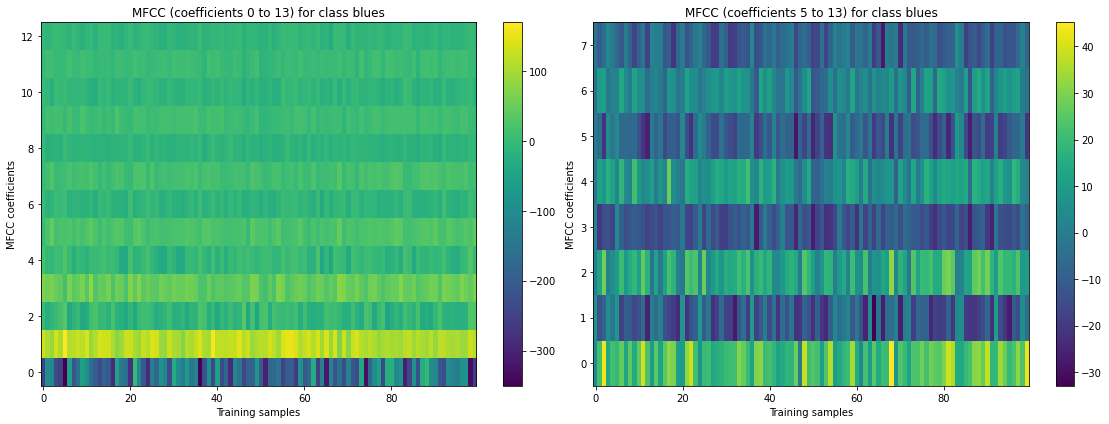

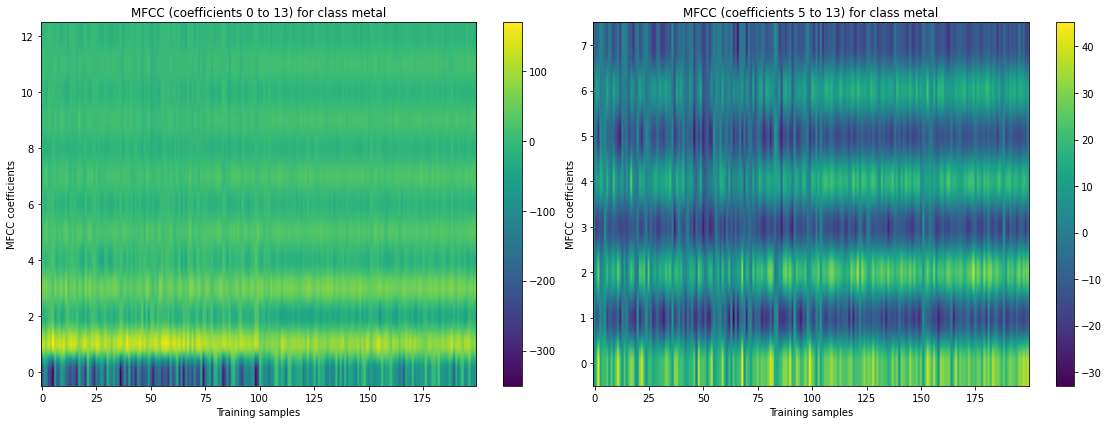

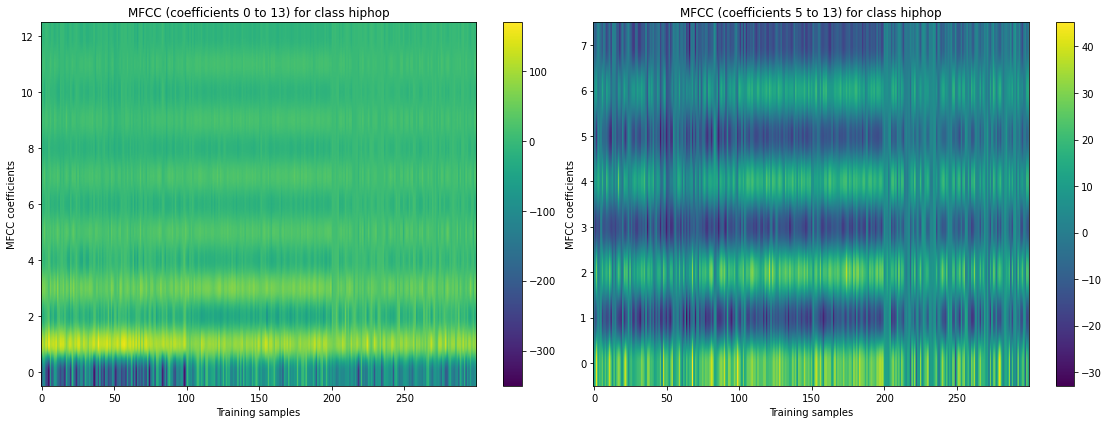

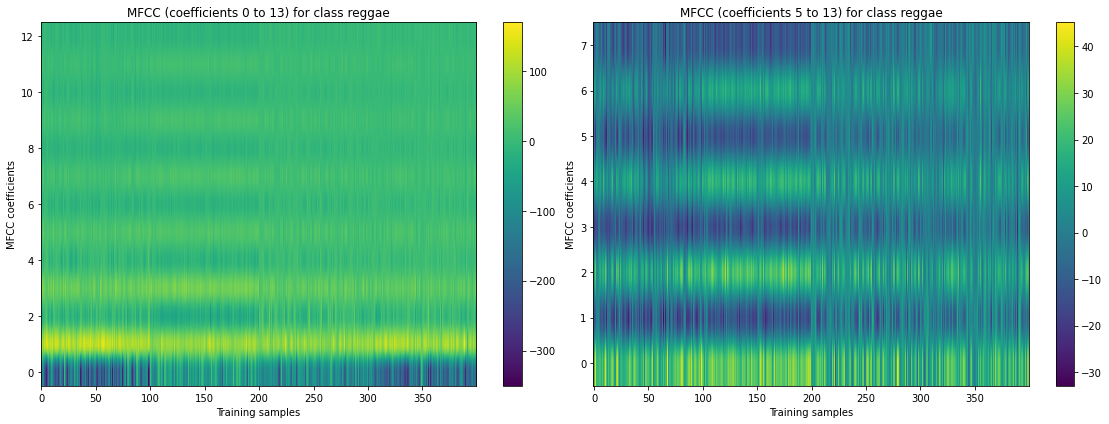

In [33]:
# store mfcc value for each genre
#mfcc_dict = {'blues':,'metal','hiohop':,'reggae':}
mfcc_dict = {"blues": [], "metal": [], "hiphop": [], "reggae": []}
for each,i in zip(genre_analysis_list,range(0,4)):
    mfcc_dict[each] = mfcc_value[0 * i: 100 * (i+1)].T
    print("Next")
for each in genre_analysis_list:
    mfcc = mfcc_dict[each]
    figure = plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)
    plt.imshow(mfcc, origin='lower', aspect='auto')
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.title('MFCC (coefficients 0 to 13) for class {}'.format(each))
    plt.colorbar()
    plt.tight_layout()

    mfcc_upper = mfcc[5:]
    plt.subplot(1,2,2)
    plt.imshow(mfcc_upper, origin='lower', aspect='auto')
    plt.title('MFCC (coefficients 5 to 13) for class {}'.format(each))
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.colorbar()
    plt.tight_layout()

Check **zero crossing rate**

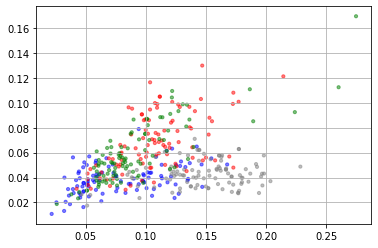

In [0]:
x = features_value['zcr1']
y = features_value['zcr2']
# set colors
color_to_genre = {'blues':'blue','metal':'grey','hiphop':'red','reggae':'green'}
colors = []
for each in genre_data['Genre']:
    colors.append(color_to_genre[each])

area = 10
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.grid(True)
plt.show()

Check **centroid**

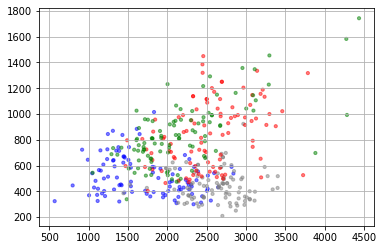

In [0]:
x = features_value['cent1']
y = features_value['cent2']
# set colors
colors = []
for each in genre_data['Genre']:
    colors.append(color_to_genre[each])

area = 10
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.grid(True)
plt.show()

**Check rms**

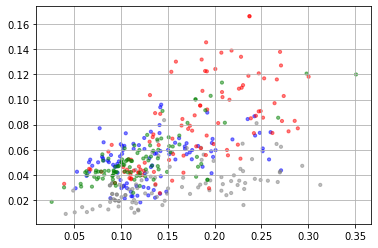

In [0]:
x = features_value['rms1']
y = features_value['rms2']
# set colors
colors = []
for each in genre_data['Genre']:
    colors.append(color_to_genre[each])

area = 10
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.grid(True)
plt.show()


## Data Spliting

What's the benefit about data spliting,

1. By dividing the data set according to a certain ratio, we can reasonably evaluate the performance of the learning algorithm in the face of unknown data.

2. If the data used to evaluate the model is not independent of the sample, the evaluation result may be inaccurate. We also want this model can be applied in a wider range of situations.



The simple way to do the data spliting is to use *sklearn.model_selection.train_test_split* to split to **Training set** and **Testing set**.


In [0]:
# sklearn provides the function to split data
#from sklearn.model_selection import train_test_split
# get the features
features = features_value

# get only the labeled genre result
result = genre_data['Genre']

# Use sklearn.train_test_split to split 80 % for training and 20% for testing
# the random seed is set to 22 here in order to see a fixed output based on this.
for each in tqdm(genre_analysis_list):
    X_train, X_test,y_train,y_test = train_test_split(
        features, result,
        test_size = 0.2,
        random_state = 22, shuffle = True)

Seconderly, another way to do the spliting, is to use **K-fold cross validating** method.

The advantage of applying this method:

1. we only have 400 audio piece in total, it's realatively a small amout of sample
2. to make the future model more accurate


**K-fold cross-validation** to do the selecting for the best parameter for the future model in order to increase the accuary dealing with unseen data.


The workflow in this part should be like this,
<div>
<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" width="500"/>
</div>

The general procedure for Cross-Validating is:

1. Shuffle the dataset randomly.
2. Split the dataset into k groups
3. For each unique group:
    - Take the group as a hold out or test data set
    - Take the remaining groups as a training data set
    - Fit a model on the training set and evaluate it on the test set
    - Retain the evaluation score and discard the model
    - Summarize the skill of the model using the sample of model evaluation scores

**Reference**
1. [Wiki](https://en.wikipedia.org/wiki/Cross-validation_(statistics))
2. [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)

## Observing the Training Set

We can visusalise the feature we want to use from the splited subset **X_train** and its genre label **y_train** .



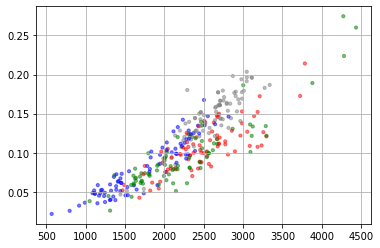

In [0]:
# test plot 1 using
x = X_train['cent1']
y = X_train['zcr1']
color_to_genre = {'blues':'blue','metal':'grey','hiphop':'red','reggae':'green'}

colors = []
for each in y_train:
    colors.append(color_to_genre[each])

area = 10
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.grid(True)
plt.show()

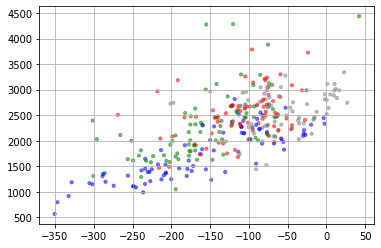

In [0]:
# test plot 2 using
x = X_train['mfcc1']
y = X_train['cent1']
color_to_genre = {'blues':'blue','metal':'grey','hiphop':'red','reggae':'green'}

colors = []
for each in y_train:
    colors.append(color_to_genre[each])

area = 10
plt.scatter(x, y, s=area, c=colors, alpha=0.5)

plt.grid(True)
plt.show()

3d

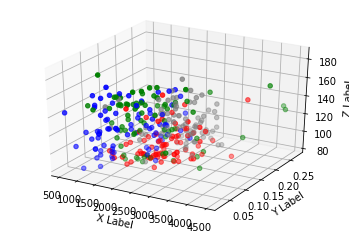

In [0]:
fig = plt.figure()
#plt.rcParams['figure.figsize'] = (20.0, 10.0)

ax = fig.add_subplot(111, projection='3d')

m = 'o'
xs = X_train['cent1']
ys = X_train['zcr1']
zs = X_train['tempo1']
ax.scatter(xs, ys, zs, marker=m,color = colors)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')


plt.show()


## Modelling

As for classifier, we can try different approaches, 

as **K Neighbour Classfier**, **Support Vector Classifier** or others.

We can test each model with the already splited dataset and try to find the best parameters to see the best result they could have.

### 0. KNN

The parameters for KNN Classifier are **searching algorithm**, **n_neighbors**, **weights** and **p** (the way to calculate distance)

Here is a simple test example using the dataset we have.

**Simple test... with random parameters**

In [0]:
kClassifier = neighbors.KNeighborsClassifier(n_neighbors=15,weights = 'distance')
kClassifier.fit(X_train,y_train)

predictedTestLabels = kClassifier.predict(X_test)
  
print(kClassifier.score(X_test,y_test))

0.7125


Now we can try to find a better k and weight to get higher score.


For the **algorithm**, we can just choose **'auto'**, since this method would choose the fatest method from the other three, 'brute', 'kd_tree', 'ball_tree'.

But for k and p, we will just enumerate all the combinations of different parameter set to check which has the highest score. 

(Is this called Grid Search to get the best parameter set?)

We can search for a better **k** with **p**



In [0]:
%%time
best_p = -1
best_score = 0.0
best_k = -1
for k in range(1, 11):
    for p in range(1, 6):
        knn_clf = neighbors.KNeighborsClassifier(n_neighbors = k, weights = "distance", p = p)
        knn_clf.fit(X_train, y_train)
        knn_score = knn_clf.score(X_test, y_test)
        if knn_score > best_score:
            best_score = knn_score
            best_k = k
            best_p = p

print("best_p = ", best_p, ", the best_k = ", best_k,", and best_score = ", best_score)


best_p =  1 , the best_k =  7 , and best_score =  0.725
CPU times: user 565 ms, sys: 1.41 ms, total: 566 ms
Wall time: 565 ms


So we can use the best parameter for training

In [0]:
kClassifier = neighbors.KNeighborsClassifier(n_neighbors=7, weights = 'distance',p =1)
kClassifier.fit(X_train,y_train)

predictedTestLabels = kClassifier.predict(X_test)
  
print(kClassifier.score(X_test,y_test))

0.725


**Confusion Matrix**

So up to now, the best parameter for current KNN model should use **k = ?, p =? **.

(With different testing data, different result of parameters)

We can get the percentage of the accuracy for the prediction result,then together with the genre label of the testdata we can plot the **Confusion Matrix** as followed.

Each **row** in the matrix is the real genre, while each **column** is the predicted genre category classified by the model we build.

From the result of this Confusion Matrix, we can clearly see that the only music genre that has been difficult for our KNN model to classify is the "Regea". The result shows that the accuracy rate is only 0.48. And 0.43 has been put in the wrong genre a "metal".


[[0.7        0.1        0.15       0.05      ]
 [0.04545455 0.54545455 0.18181818 0.22727273]
 [0.05882353 0.05882353 0.88235294 0.        ]
 [0.14285714 0.04761905 0.         0.80952381]]


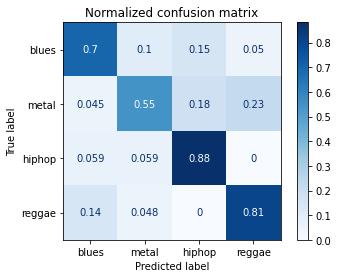

In [0]:
#from sklearn.metrics import plot_confusion_matrix
# plot confusion matrix
title = "Normalized confusion matrix"
disp = plot_confusion_matrix(kClassifier,X_test, y_test,
                                 display_labels=genre_analysis_list, # genre names list
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title(title)

print()
print(disp.confusion_matrix)

plt.show()

### Decision Tree


[0.8   0.8   0.725 0.525 0.725 0.675 0.625 0.75  0.525 0.75 ] avg_score:  0.6900000000000001


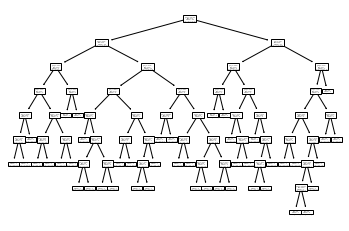

In [0]:
from sklearn import tree

tree_classifier = tree.DecisionTreeClassifier()
tree_classifier = tree_classifier.fit(X_train,y_train)
tree_classifier.predict(X_test)
tree.plot_tree(tree_classifier)

scores = cross_val_score(tree_classifier, features, result, cv=10)
print(scores,'avg_score: ',np.mean(scores))
# can see clearly the plot

In [0]:
# How to get the best parameter for Decision Tree
# not that familiar with each parameter
# need to check https://scikit-learn.org/stable/modules/tree.html#classification
tuned_parameters = [{'criterion': ['rbf'], 'splitter': [1e-3, 1e-4],
                     'max_depth': [1, 10, 100, 1000]}

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    tre = GridSearchCV(
        tree_classifier, tuned_parameters, scoring='%s_macro' % score
    )
    tre.fit(X_train, y_train)

# Tuning hyper-parameters for 0.675



NameError: ignored

### 1. SVC: Support Vector Classifier

using sklearn [SVM](https://scikit-learn.org/stable/modules/svm.html#classification)

In this part, we can use the simplest svm to get get prediction of the music genre using test data.

In [0]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

X = X_train #feature training data
Y = y_train # genre
clf = svm.SVC(decision_function_shape='ovo')

# the predicted result
clf.fit(X, Y)
#print(clf.predict(X_test))
# check the score of the predicted result
scores = cross_val_score(clf,features,result, cv=5)
np.mean(scores)


0.5974999999999999

Plot the prediction result and the difference between the test result.


**Get the best parameters**

Slow...

In [0]:

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']
print("Still searching....please wait...")
for score in tqdm(scores):
    print("# Tuning hyper-parameters for %s" % score)
    print()
    # use Parallelism
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    clf = GridSearchCV(
        svm.SVC(), tuned_parameters, scoring='%s_macro' % score, n_jobs = -1)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

Still searching....please wait...


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1, 'kernel': 'linear'}

Grid scores on development set:

0.553 (+/-0.207) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.619 (+/-0.134) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.619 (+/-0.146) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.606 (+/-0.105) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.619 (+/-0.146) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.599 (+/-0.108) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.619 (+/-0.146) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.599 (+/-0.108) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.731 (+/-0.081) for {'C': 1, 'kernel': 'linear'}
0.705 (+/-0.092) for {'C': 10, 'kernel': 'linear'}
0.690 (+/-0.105) for {'C': 100, 'kernel': 'linear'}
0.696 (+/-0.077) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full eva

Then, we can see the best parameter set
{'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}


[[0.8        0.1        0.         0.1       ]
 [0.04545455 0.59090909 0.09090909 0.27272727]
 [0.05882353 0.05882353 0.88235294 0.        ]
 [0.23809524 0.19047619 0.         0.57142857]]


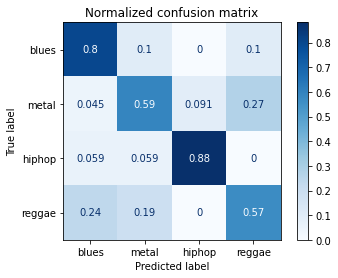

In [0]:
from sklearn.metrics import plot_confusion_matrix
# plot confusion matrix
title = "Normalized confusion matrix"
clf = svm.SVC(C=1.0,kernel ='linear')
clf.fit(X, Y)
disp = plot_confusion_matrix(clf,X_test, y_test,
                                 display_labels=genre_analysis_list, # genre names list
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title(title)

print()
print(disp.confusion_matrix)

plt.show()

Need to check 

https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py


## Cross Validation


In [0]:
%%time
best_p = -1
best_score = 0.0
best_k = -1
for k in range(1, 11):
    for p in range(1, 6):
        knn_clf = neighbors.KNeighborsClassifier(n_neighbors = k, weights = "distance", p = p)
        knn_clf.fit(X_train, y_train)

        knn_score = knn_clf.cross_val_score(features, result)
        if knn_score > best_score:
            best_score = knn_score
            best_k = k
            best_p = p

print("best_p = ", best_p, ", the best_k = ", best_k,", and best_score = ", best_score)


NameError: ignored

## Evaluation

## Optimization


https://scikit-learn.org/stable/modules/grid_search.html#grid-search

In [0]:
# use param_grid
# estimator.get_params()
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

## Final Conclusion

To Do...

## Feature Extraction 1: MFCC + Chroma_stft




 Save source data in **genres.csv**

In [0]:
# save data in genre.csv
genre_analysis_list = ["blues","metal","hiphop","reggae"]  
genre_list = []  
path_list = []
train_path = "../root/dataset/genres/"

for each in genre_analysis_list:
    train_test_folder = train_path + format(each)
    train_catg_files = [f for f in os.listdir(train_test_folder) if f.endswith('.au')]
    for index, each_file in enumerate(train_catg_files):
        each_file_path = os.path.join(train_test_folder, each_file)
        genre_list.append(each)
        path_list.append(each_file_path)
genre_data = pd.DataFrame(list(zip(genre_list,path_list)),columns = ['Genre','Path'])
genre_data.to_csv('./genres.csv',sep = '\t', index = False)

genre_data


,Genre,Path
0,blues,../root/dataset/genres/blues/blues.00020.au
1,blues,../root/dataset/genres/blues/blues.00093.au
2,blues,../root/dataset/genres/blues/blues.00076.au
3,blues,../root/dataset/genres/blues/blues.00099.au
4,blues,../root/dataset/genres/blues/blues.00004.au
...,...,...
395,reggae,../root/dataset/genres/reggae/reggae.00064.au
396,reggae,../root/dataset/genres/reggae/reggae.00085.au
397,reggae,../root/dataset/genres/reggae/reggae.00006.au
398,reggae,../root/dataset/genres/reggae/reggae.00066.au


Extract **Mfcc** and **Chroma** as features to analysis.

Save them in pd.DataFrame and also in **'features.cs''** file.

In [0]:
# save MFCC feature in features.csv
mfcc_list = []
mfcc_value = np.zeros((400, 13))
chroma_value = np.zeros((400, 12))

columns =[]
for mfcc_i in range(0,13):
    columns.append('mfcc'+str(mfcc_i))

for each_file, index in zip(genre_data['Path'],range(0,400)):
    hop_length = 512
    y, sr = librosa.load(each_file)
    oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    print("Now processing:",each_file)
    # get feature mfcc
    features_mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13) 
    mfcc_value[index,:] = np.mean(features_mfcc,axis=1)
    
    # get feature chroma
    features_chroma = librosa.feature.chroma_stft(y,sr)
    chroma_value[index, :] = np.mean(features_chroma, axis=1)
    
    # test print
    #print("MFCC: ", mfcc_value)
    #print("Chroma: ", chroma_value)


# feature_table is the df of mfcc_value
features_value = pd.DataFrame(mfcc_value)
# add other feature, chroma also inside this table

# test
#print(pd.concat([feature_table, pd.DataFrame(chroma_value)], axis=1))

# update features_value and save to .csv
features_value = pd.concat([features_value, pd.DataFrame(chroma_value)], axis=1)

# update the features_value dataframe column name to mfcc1 to mfcc13, chroma 1 to 12
col_name = []
for index in range(0,13):
    col_name.append('mfcc'+str(index+1))
for index in range(0,12):
    col_name.append('chroma'+str(index+1))
# print(col_name)
features_value.columns = col_name
# save to .csv
features_value.to_csv('./features.csv',sep = '\t', index = False)

    
features_value


Here we can print the result to check.

In [0]:
# print test
print(features_value.head(10))
print(features_value.columns)
print(features_value.index)

features_value.columns = col_name
print(features_value.head(1))

## * Playground 1(Test 0410 )

## * Playground 2(Feature Extracting Single Test)

This part is just the first attempt to get some features from dataset. 

Not useful anymore.

we are goint to extract some features using librosa library.

1. Feature Selecting
- **mfcc**: librosa.feature.mfcc, num =13
- **chroma**: num = 12
- tempogram: librosa.feature.tempogram
- melspectrogram: librosa.feature.melspectrogram


2. Feature extracting: **mfcc**

In [0]:
dict_train_features_mfcc = {"blues": [], "metal": [], "hiphop": [], "reggae": []}

n_mfcc = 13 
# try: change back to 13
train_path = "../root/dataset/genres/"

for each in genre_analysis_list:
    train_test_folder = train_path + format(each)
    #the current folder/categories
    print("Current train_test_folder is: " + train_test_folder)

    train_catg_files = [f for f in os.listdir(train_test_folder) if f.endswith('.au')]
    #print(train_catg_files)
    n_train_samples = len(train_catg_files) 
    #how much files in each category
    print("Number of training samples in this category: ", n_train_samples)
    
    #store feature result
    train_features = np.zeros((n_train_samples, n_mfcc))
    
    #print(train_features)
    for index, each_file in enumerate(train_catg_files):
        each_file_path = os.path.join(train_test_folder, each_file)
        y, sr = librosa.load(each_file_path)
        
        feature_mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13) 
        train_features[index, :] = np.mean(feature_mfcc, axis=1)

    dict_train_features_mfcc[each] = train_features
    print(dict_train_features_mfcc)


Check to see mfcc data

In [0]:
print(dict_train_features_mfcc)

In [0]:
for each in dict_train_features_mfcc:

    pdmfcc = pd.DataFrame(dict_train_features_mfcc[each])
    print("Current: ",each)
    print("\n",pdtest)
    # add to dataframe
source_data['mfcc'] = pdmfcc
print(source_data)
# df['Address'] = address 
    #pdtest.to_csv("source_data.csv")

3. Feature extracting: **chroma**

In [0]:
dict_train_features_chroma = {"blues": [], "metal": [], "hiphop": [], "reggae": []}
for each in ana_class:
    train_test_folder = train_path + format(each)
    print("Current train_test_folder is: " + train_test_folder) #current folder
    train_catg_files = [f for f in os.listdir(train_test_folder) if f.endswith('.au')]
    n_train_samples = len(train_catg_files)
    n_size = 12
    train_features = np.zeros((n_train_samples,n_size)) # 12

    for index, each_file in enumerate(train_catg_files):
        each_file_path = os.path.join(train_test_folder, each_file)
        y, sr = librosa.load(each_file_path)
        #new feature
        feature_chroma = librosa.feature.chroma_stft(y,sr)
        train_features[index, :] = np.mean(feature_chroma, axis=1)

    dict_train_features_chroma[each] = train_features
#Test
print("---\n Testing...")
print(dict_train_features_chroma["blues"])

In [0]:
pd = pandas.DataFrame(dict_train_features_chroma)
pd.to_csv("test.csv")

3. Feature extracting: **tempogram** 

    Not using this feature right now, as I am not sure. There might be some problems with the window length need to be fixed.





**Function calculate_features**

Define a function calculate any feature we want by walking through the file of specific genres.

In [0]:
def calculate_feature(categories = ["blues","metal","hiphop","reggae"] ,something):
    """

    """
    

    return dict_feature

## Playground 3(Feature Extraction)

In [0]:
train_path = "../root/dataset/genres/"
genre_list = []
path_list = []
mfcc_list = []
chroma_list= []

# The list of genres we need to analysis
genre_analysis_list = ["blues","metal","hiphop","reggae"]    

# Go throug the file of each genre
for each in genre_analysis_list:
    train_test_folder = train_path + format(each)
    # To see current folder of this genre
    print("Current train_test_folder is: " + train_test_folder)

    train_catg_files = [f for f in os.listdir(train_test_folder) if f.endswith('.au')]
    
    train_features = np.zeros((100, 13)) #define n_mfcc =13
    train_features_c = np.zeros((100, 12)) 
    for index, each_file in enumerate(train_catg_files):
        # get file_path
        each_file_path = os.path.join(train_test_folder, each_file)
        # get y, sample rate
        y, sr = librosa.load(each_file_path) 
        # calculate mfcc, num = 13, store in train_features
        feature_mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13) 
        train_features[index, :] = np.mean(feature_mfcc, axis=1)
        # calculate chroma, num =12
        features_chroma = librosa.feature.chroma_stft(y,sr)
        train_features_c[index, :] = np.mean(features_chroma, axis=1)

        # Add to list to store
        genre_list.append(each)
        path_list.append(each_file_path)
        mfcc_list.append(train_features[index])
        # Add feature chroma
        chroma_list.append(train_features_c[index])


# Create a new Pandas Data Frame to store the result
# With Column: "Genre", "File_path", "Est_tempo"
# can also add f1, f2 ... other features
source_data = pd.DataFrame(
    list(zip(genre_list,path_list)), #path_list
               columns =['Genre', 'File_path']) 

source_data['MFCC'] =  mfcc_list    
source_data['Chroma'] =  chroma_list  
# Export the dataframe we need to a csv file 
source_data.to_csv('./source_data.csv', sep = '\t', index=False)

In [0]:
# Test print
print("Test ---")
print(source_data)

print(source_data['MFCC'])


We can also download the **'source_data.csv'** to check.

Thus, we need to split the data into two part( 80% : 20%) in order to have totally different data with labels for training and testing individually.

And now we have two choosen features, mfcc(num=13), chroma(num=12) to deal with.

From the test, we can see the whole dataset has been splited into two subset, one is **X_train** for training our model, the other is **X_test** for testing. 

The **y_train**, and y_test is the value of music genres(the label we have).

This part is just playing with pandas.

Not useful anymore

---


In [0]:
audio_piece = {'Genre': ['blues','metal','hiphop','reggae'],
        'Path': ['a','b','c','d']
        }

df = pd.DataFrame(audio_piece, columns= ['Genre', 'Path'])

print (df)
audio =['a','file_path',3]
d = pd.DataFrame(audio,columns=['name','path'])
print(d)

play with a simple audio file

In [0]:
path = "../root/dataset/genres/blues/blues.00000.au"
y, sr = librosa.load(path) # samplerate
#c_path = librosa.util.example_audio_file()
#sample_rate = librosa.get_samplerate(c_path)

tempo, beat_frames = librosa.beat.beat_track(y, sr)

f_mfcc = librosa.feature.mfcc(y, sr)
duration = librosa.get_duration(y, sr)
rms = librosa.feature.rms(y)
mels = librosa.feature.melspectrogram(y,sr) #calculate the melspectrogram
spt_flat = librosa.feature.spectral_flatness(y)
feature_tempogram = librosa.feature.tempogram(y, sr,10)
feature_chroma = librosa.feature.chroma_stft(y,sr)

print("current file: ", path, "with sample rate: ", sr) # 
#print("y = ", y)
print('The Estimated tempo is : {:.2f} beats per minute'.format(tempo))
print("mfcc = ", f_mfcc)
print("The duration of the file is: ", duration, "in seconds")
print("RMS: ", rms)
print("MELS: ", mels)
print("Spectral Flatness:", spt_flat)
print("len of Spectral Flatness:", len(spt_flat))
print("feature_tempogram:",feature_tempogram)
print("len of feature_tempogram:", len(feature_tempogram))

print("feature_chroma:",feature_chroma)
print("len of feature_chroma:", len(feature_chroma))



What we can get from the sample audio file as **general information**,
1. basic info: sample rate, duration of the file, estimated tempo
2. low level feature info:
    - mfcc (recognition)
    - melspectrogram
    - spectral_flatness (tonal)
3. high level feature info {consist of low level features}


Using the four categories {Blues, Metal, Hip-hop, Reggae} as instructed.

In [0]:
#we need to analysis Blues, Metal, Hip-Hop, Reggae
ana_class = ["blues","metal","hiphop","reggae"] 
dict_train_features = {"blues": [], "metal": [], "hiphop": [], "Reggae": []}
n_mfcc = 20
# try: change back to 13
train_path = "../root/dataset/genres/"


for each in ana_class:
    train_test_folder = train_path + format(each)
    #the current folder/categories
    print("Current train_test_folder is: " + train_test_folder)

    train_catg_files = [f for f in os.listdir(train_test_folder) if f.endswith('.au')]
    #print(train_catg_files)
    n_train_samples = len(train_catg_files) 
    #how much files in each category
    print("Number of training samples in this category: ", n_train_samples)
    
    #store feature result
    train_features = np.zeros((n_train_samples, n_mfcc))
    
    #print(train_features)
    for index, each_file in enumerate(train_catg_files):
        each_file_path = os.path.join(train_test_folder, each_file)
        y, sr = librosa.load(each_file_path)
        feature_mfcc = librosa.feature.mfcc(y, sr)
        train_features[index, :] = np.mean(feature_mfcc, axis=1)
        #print("train_features", train_features)
        #dont need tempo in this way, for now...
        #tempo, beat_frames = librosa.beat.beat_track(y, sr)
        #print("Estimated tempo: ", tempo)

    dict_train_features[each] = train_features
    print(dict_train_features["blues"])

Current train_test_folder is: ../root/dataset/genres/blues
Number of training samples in this category:  100
[[-1.21448978e+02  9.60805375e+01 -1.95898421e+01 ... -2.04378116e+00
  -1.76269026e+00 -3.96245312e+00]
 [-1.21363940e+02  1.22506683e+02 -1.47381965e+01 ...  2.69524786e+00
   3.41230547e+00 -2.71569238e+00]
 [-3.00981873e+01  1.03732518e+02 -1.97379711e+01 ...  4.72184211e+00
   4.90646799e-01  1.47166699e+00]
 ...
 [-1.55558833e+02  1.25645326e+02  1.60112256e+00 ...  9.69413886e-01
   2.02691569e+00 -5.73704447e+00]
 [-1.45280972e+02  1.02806649e+02 -1.25294329e+01 ... -9.52051838e-01
   2.25845906e-02 -2.00456166e+00]
 [-5.26972475e+01  7.44333591e+01 -1.86967667e+01 ...  3.68983828e+00
  -4.93847515e+00  4.42173063e+00]]
Current train_test_folder is: ../root/dataset/genres/metal
Number of training samples in this category:  100
[[-1.21448978e+02  9.60805375e+01 -1.95898421e+01 ... -2.04378116e+00
  -1.76269026e+00 -3.96245312e+00]
 [-1.21363940e+02  1.22506683e+02 -1.4738

**Visulise the features of MFCC**


Something seems wrong...

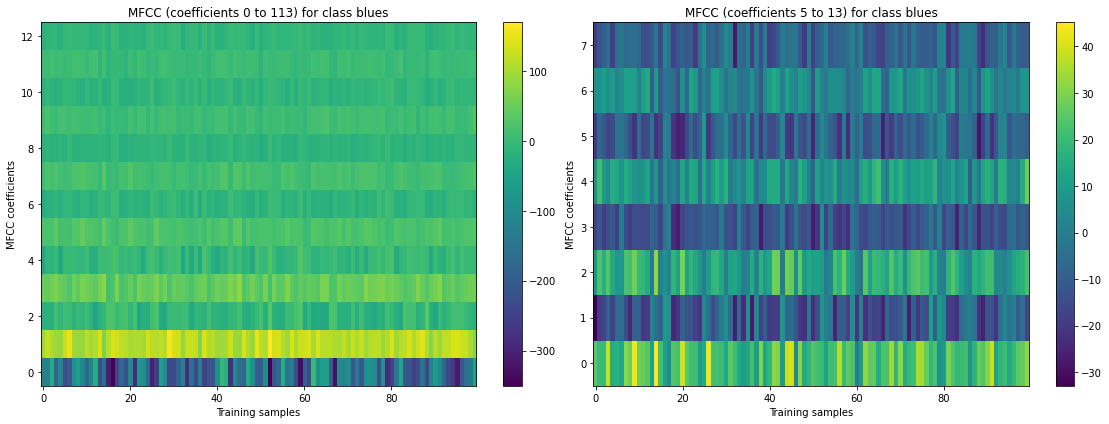

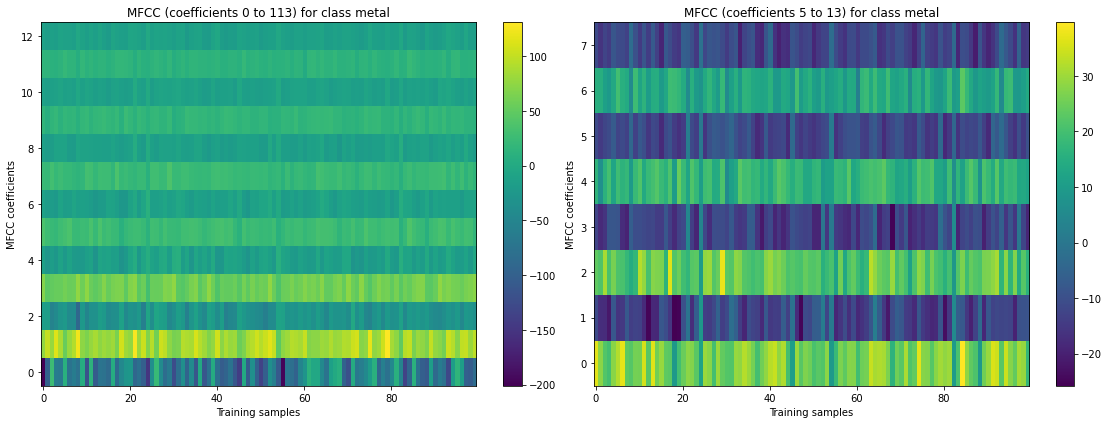

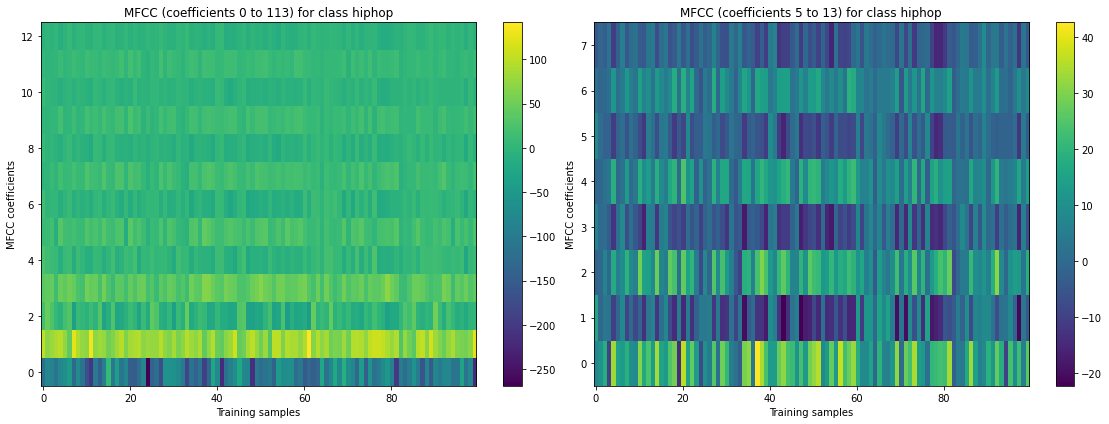

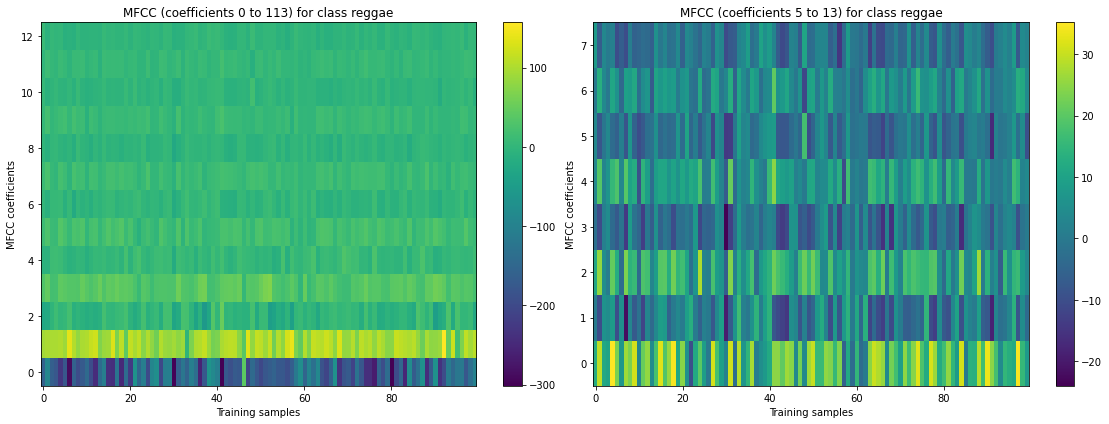

In [0]:
for each in ana_class:
    mfcc = dict_train_features_mfcc[each].transpose()
    
    # Visualization
    figure = plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)
    plt.imshow(mfcc, origin='lower', aspect='auto')
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.title('MFCC (coefficients 0 to 113) for class {}'.format(each))
    plt.colorbar()
    plt.tight_layout()

    mfcc_upper = mfcc[5:]
    plt.subplot(1,2,2)
    plt.imshow(mfcc_upper, origin='lower', aspect='auto')
    plt.title('MFCC (coefficients 5 to 13) for class {}'.format(each))
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.colorbar()
    plt.tight_layout()

## Playground 4(SVC)


In [0]:
sklearn.svm.SVC()

NameError: ignored

## About Team Work
**0410 Discussion**
1. apply preprocessing to audio files
2. how to split our dataset to {training, testing} to make sure the difference of the two groups
3. check if our dataset is balanced? Actually it is already balanced.
4. which set of features can to useful for our cases
5. apply feature selection?
6. choose which classification method?
7. try different parameter for the classfier
8. evaluate the model
9. display the result
**0411 Discussion**
1. do some test individually, using different classfiers


## Reference Materials

1. librosa
2. sklearn
3. pattern recognition, 
4. "The GTZAN dataset: Its contents, its faults, their effects on evaluation, and its future us", Bob L. Sturm, [2013], https://arxiv.org/abs/1306.1461